#     Minerva - Modelo Detección Fake News - TEXTOS LARGOS
===========================================================================================================

## 1. Importamos librerías

In [1]:
#General
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#Tratamiento de Texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import SnowballStemmer
from wordcloud import WordCloud, ImageColorGenerator
import string
import re
import spacy

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, datasets
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

#Keras/Tf
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Paquetes que es necesario instalar por primera vez

In [2]:
#pip install --user -U nltk
#nltk.download('wordnet')
#pip install -U spacy
# pip install wordcloud
# !python -m spacy download en_core_web_sm
#!python -m spacy download es

## 2. Importamos dataset

### 2.1. Datasets fake

Los archivos de fake news utilizados en esta ejecución son los siguientes:

* elmundotoday_07072020.csv
* elmundotoday_08072020.csv
* elmundotoday_09072020.csv
* elmundotoday_10072020.csv
* fake_news_10072020.csv
* fake_news_12072020.csv
* fake_news_13072020.csv
* fake_news_14072020.csv
* fake_news_15072020.csv
* fake_news_16072020.csv
* fake_news_17072020.csv
* fake_news_18072020.csv
* extra_fakes_18072020.csv
* fake_news_19072020.csv
* eljueves_19072020.csv
* eljueves_política_19072020
* fake_news_20072020.csv

In [3]:
path = r'C:/Users/User/Desktop/Master/TFM/Fake_News/data/fake' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_fake = pd.read_csv(filename, encoding='utf-8-sig', sep= ";")
    li.append(df_fake)

df_fake = pd.concat(li, axis=0, ignore_index=True)

In [4]:
df_fake.head(5)

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
0,0,El Jueves,Abascal desmiente que las chorradas que dice e...,NaN,NaN,NaN,El hackeo masivo de cuentas a famosos y perso...,NaN,https://www.eljueves.es/news/abascal-desmiente...,NaN
1,1,El Jueves,Felipe González se deja de mierdas y se afilia...,NaN,NaN,NaN,"""Estoy hasta los cojones de tanto rojo"", afirm...",NaN,https://www.eljueves.es/news/felipe-gonzalez-s...,NaN
2,2,El Jueves,La Generalitat disfrazará de Colombo a sus ras...,NaN,NaN,NaN,"""Total, tampoco vamos a gastar mucho en disfra...",NaN,https://www.eljueves.es/news/generalitat-disfr...,NaN
3,3,El Jueves,Encuentran a Juan Carlos I abandonado en una g...,NaN,NaN,NaN,"""No sé qué ha sucedido. Estábamos en el coche ...",NaN,https://www.eljueves.es/news/encuentran-juan-c...,NaN
4,4,El Jueves,La encargada de realizar las encuestas del CIS...,NaN,NaN,NaN,El presidente colocó a su abuela en el Institu...,NaN,https://www.eljueves.es/news/encargada-realiza...,NaN


Analizamos los vacíos

In [5]:
df_fake[df_fake["Texto"].isnull()]

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
369,369,El Jueves,Miles de españoles podrían pedir la baja por e...,NaN,NaN,NaN,NaN,NaN,https://www.eljueves.es/news/miles-espanoles-p...,NaN
403,403,El Jueves,#PonleChiste: Los líderes del Trifachito se va...,NaN,NaN,NaN,NaN,NaN,https://www.eljueves.es/news/ponlechiste-lider...,NaN
412,412,El Jueves,#PonleChiste: Iglesias y Sánchez negocian en e...,NaN,NaN,NaN,NaN,NaN,https://www.eljueves.es/news/ponlechiste-igles...,NaN
422,422,El Jueves,#PonleChiste: Iglesias y Sánchez siguen negoci...,NaN,NaN,NaN,NaN,NaN,https://www.eljueves.es/news/ponlechiste-igles...,NaN
431,431,El Jueves,#PonleChiste: Pablo Casado emprende el vuelo,NaN,NaN,NaN,NaN,NaN,https://www.eljueves.es/news/ponlechiste-pablo...,NaN
...,...,...,...,...,...,...,...,...,...,...
5618,55,Maldita,Cuidado con este falso SMS de Bankia que te al...,Autor,0.0,NaN,NaN,1.0,NaN,new_56
5619,56,Maldita,esta mujer que explica cómo hacer una felación...,Autor,0.0,NaN,NaN,1.0,NaN,new_57
5620,57,Maldita,Cuidado con la falsa “alerta policial” de la b...,Autor,0.0,NaN,NaN,1.0,NaN,new_58
5621,58,Maldita,"¿Qué sabemos sobre la nueva neumonía ""más leta...",Autor,0.0,NaN,NaN,1.0,NaN,new_59


Si la noticia está vacía ponemos el titular

In [6]:
df_fake["Texto"]= df_fake.apply(lambda x: x['Título'] if pd.isnull(x['Texto']) else x['Texto'], axis=1)

In [7]:
df_fake[df_fake["Texto"].isnull()]

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
2771,72,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_73
3578,72,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_73
3894,388,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_389
3896,390,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_391
3898,392,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_393
3900,394,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_395
3902,396,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_397
3904,398,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_399
3906,400,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_401
3908,402,Newtral/Fakes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,new_403


Eliminamos los vacíos

In [8]:
df_fake = df_fake[df_fake.Texto.notnull()]

Comprobamos que ya no hay vacíos

In [9]:
df_fake[df_fake["Texto"].isnull()]

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id


Eliminamos las fake news que figuran como con suscripción y que no son fake news reales

In [10]:
df_fake = df_fake[~df_fake['Texto'].str.contains("Accede a tu cuenta ¡Suscríbete ahora!")]

In [11]:
df_fake.head(5)

,Unnamed: 0,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,new_id
0,0,El Jueves,Abascal desmiente que las chorradas que dice e...,NaN,NaN,NaN,El hackeo masivo de cuentas a famosos y perso...,NaN,https://www.eljueves.es/news/abascal-desmiente...,NaN
1,1,El Jueves,Felipe González se deja de mierdas y se afilia...,NaN,NaN,NaN,"""Estoy hasta los cojones de tanto rojo"", afirm...",NaN,https://www.eljueves.es/news/felipe-gonzalez-s...,NaN
2,2,El Jueves,La Generalitat disfrazará de Colombo a sus ras...,NaN,NaN,NaN,"""Total, tampoco vamos a gastar mucho en disfra...",NaN,https://www.eljueves.es/news/generalitat-disfr...,NaN
3,3,El Jueves,Encuentran a Juan Carlos I abandonado en una g...,NaN,NaN,NaN,"""No sé qué ha sucedido. Estábamos en el coche ...",NaN,https://www.eljueves.es/news/encuentran-juan-c...,NaN
4,4,El Jueves,La encargada de realizar las encuestas del CIS...,NaN,NaN,NaN,El presidente colocó a su abuela en el Institu...,NaN,https://www.eljueves.es/news/encargada-realiza...,NaN


Noticias de El Jueves

In [12]:
df_fake_jueves = df_fake[df_fake['Web'].str.contains("Jueves")]
df_fake_jueves.shape

(2308, 10)

Noticias El Mundo Today

In [13]:
df_fake_today = df_fake[df_fake['Web'].str.contains("Today")]
df_fake_today.shape

(417, 10)

In [14]:
df_fake = pd.concat([df_fake_jueves, df_fake_today], ignore_index=True)

In [15]:
df_fake.shape

(2725, 10)

Nos quedamos únicamente con el cuerpo de la noticia

In [16]:
df_fake = df_fake[["Texto"]]

In [17]:
df_fake.head(5)

,Texto
0,El hackeo masivo de cuentas a famosos y perso...
1,"""Estoy hasta los cojones de tanto rojo"", afirm..."
2,"""Total, tampoco vamos a gastar mucho en disfra..."
3,"""No sé qué ha sucedido. Estábamos en el coche ..."
4,El presidente colocó a su abuela en el Institu...


Analizamos la forma del dataset

In [18]:
df_fake.shape

(2725, 1)

Quitamos duplicados

In [19]:
df_fake = df_fake.drop_duplicates()

In [20]:
df_fake.shape

(2311, 1)

Añadimos un label de que es fake (target=1)

In [21]:
df_fake["Target"] =1

In [22]:
df_fake.head(5)

,Texto,Target
0,El hackeo masivo de cuentas a famosos y perso...,1
1,"""Estoy hasta los cojones de tanto rojo"", afirm...",1
2,"""Total, tampoco vamos a gastar mucho en disfra...",1
3,"""No sé qué ha sucedido. Estábamos en el coche ...",1
4,El presidente colocó a su abuela en el Institu...,1


Guardamos una variable con el tamaño de las fake news que en pasos posteriores utilizaremos

In [23]:
size_fake_news=df_fake.shape[0]
print(size_fake_news)

2311


### 2.2. Datasets reales

Los archivos de noticias reales utilizados para esta ejecución son los siguientes:

* news_completo_07072020
* news_completo_08072020
* news_completo_09072020
* news_completo_10072020
* news_completo_11072020
* news_completo_12072020
* news_completo_12072020
* news_completo_13072020
* news_completo_14072020
* news_completo_15072020
* news_completo_16072020
* news_completo_17072020
* news_completo_18072020
* news_completo_19072020
* news_completo_20072020

Se leen los archivos de la ruta, se leen con pandas y se concatenan

In [24]:
path = r'C:/Users/User/Desktop/Master/TFM/Fake_News/data/real' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_real = pd.read_csv(filename, encoding='utf-8-sig', sep= ";")
    li.append(df_real)

df_real = pd.concat(li, axis=0, ignore_index=True)

In [25]:
df_real.head(5)

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha
0,0,new_1,El Confidencial,Marjaliza detalla ante el juez las supuestas m...,Pablo Gabilondo,1,1,07/07/2020 14:14 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
1,1,new_2,El Confidencial,"País Vasco cree que el brote de Ordizia, con 3...",Agencias,0,120,07/07/2020 08:22 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
2,2,new_3,El Confidencial,Ayuso siempre se adelantó: el PP de Madrid vue...,A. Pérez Giménez,0,15,07/07/2020 11:04La presidenta de la Comunidad ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
3,3,new_4,El Confidencial,Sanidad no tiene datos fiables de muertes por ...,EFE,0,6,07/07/2020 09:14 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07
4,4,new_5,El Confidencial,Dimite uno de los fichajes de Hernàndez en RTV...,Víctor Romero. Valencia,0,6,07/07/2020 05:00 - ...,1,https://www.elconfidencial.com/espana/2020-07-...,2020-07-07


Analizamos los vacíos

In [26]:
df_real[df_real["Texto"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha
157,157,new_158,El Confidencial,Fiscales reclaman un criterio técnico en las q...,Beatriz Parera,0,41,NaN,10,https://www.elconfidencial.com/espana/2020-06-...,2020-06-19
172,172,new_173,El Confidencial,Almeida gana: el juez deja sin efecto su citac...,Beatriz Parera,0,10,NaN,11,https://www.elconfidencial.com/espana/2020-05-...,2020-05-22
190,190,new_191,El Confidencial,Sant Cugat reclama a JxCAT el dinero que robó ...,Antonio Fernández. Barcelona,0,4,NaN,12,https://www.elconfidencial.com/espana/cataluna...,2020-05-20
193,193,new_194,El Confidencial,Sanidad compra 3 millones de monos a la empres...,Europa Press,0,2,NaN,12,https://www.elconfidencial.com/espana/2020-05-...,2020-05-19
396,129,new_130,El Confidencial,Sanidad suma 9 muertes y los contagios en dos ...,Javier Corbacho,0,5,NaN,8,https://www.elconfidencial.com/espana/2020-06-...,2020-06-30
...,...,...,...,...,...,...,...,...,...,...,...
11198,995,eco_996,Expansión,Swan 98: Así cobra vida el nuevo 'cisne' de 30...,A. MAS,0,NaN,NaN,1,https://www.expansion.com/nauta360/vela/2020/0...,2020-07-17
11206,1003,eco_1004,Expansión,"Disney reduce ""drásticamente"" su publicidad en...",NaN,0,NaN,NaN,1,https://www.expansion.com/economia-digital/com...,2020-07-19
11212,1009,eco_1010,Expansión,Las claves bursátiles de la semana,RAMÓN FORCADA,0,NaN,NaN,1,https://videos.expansion.com/v/0_8dkr4swf,--
11214,1011,eco_1012,Expansión,Valores que se disparan en Bolsa,C. ROSIQUE / T. VÁZQUEZ,0,NaN,NaN,1,https://videos.expansion.com/v/0_yo5dwd7h-valo...,--


In [27]:
df_real[df_real["Texto"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha
157,157,new_158,El Confidencial,Fiscales reclaman un criterio técnico en las q...,Beatriz Parera,0,41,NaN,10,https://www.elconfidencial.com/espana/2020-06-...,2020-06-19
172,172,new_173,El Confidencial,Almeida gana: el juez deja sin efecto su citac...,Beatriz Parera,0,10,NaN,11,https://www.elconfidencial.com/espana/2020-05-...,2020-05-22
190,190,new_191,El Confidencial,Sant Cugat reclama a JxCAT el dinero que robó ...,Antonio Fernández. Barcelona,0,4,NaN,12,https://www.elconfidencial.com/espana/cataluna...,2020-05-20
193,193,new_194,El Confidencial,Sanidad compra 3 millones de monos a la empres...,Europa Press,0,2,NaN,12,https://www.elconfidencial.com/espana/2020-05-...,2020-05-19
396,129,new_130,El Confidencial,Sanidad suma 9 muertes y los contagios en dos ...,Javier Corbacho,0,5,NaN,8,https://www.elconfidencial.com/espana/2020-06-...,2020-06-30
...,...,...,...,...,...,...,...,...,...,...,...
11198,995,eco_996,Expansión,Swan 98: Así cobra vida el nuevo 'cisne' de 30...,A. MAS,0,NaN,NaN,1,https://www.expansion.com/nauta360/vela/2020/0...,2020-07-17
11206,1003,eco_1004,Expansión,"Disney reduce ""drásticamente"" su publicidad en...",NaN,0,NaN,NaN,1,https://www.expansion.com/economia-digital/com...,2020-07-19
11212,1009,eco_1010,Expansión,Las claves bursátiles de la semana,RAMÓN FORCADA,0,NaN,NaN,1,https://videos.expansion.com/v/0_8dkr4swf,--
11214,1011,eco_1012,Expansión,Valores que se disparan en Bolsa,C. ROSIQUE / T. VÁZQUEZ,0,NaN,NaN,1,https://videos.expansion.com/v/0_yo5dwd7h-valo...,--


In [28]:
df_real["Texto"]= df_real.apply(lambda x: x['Título'] if pd.isnull(x['Texto']) else x['Texto'], axis=1)

Eliminamos los vacíos

In [29]:
df_real = df_real[df_real.Texto.notnull()]

Comprobamos que ya no hay vacíos

In [30]:
df_real[df_real["Texto"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL,Fecha


Nos quedamos únicamente con el cuerpo de la noticia

In [31]:
df_real = df_real[["Texto"]]

In [32]:
df_real.head(5)

,Texto
0,07/07/2020 14:14 - ...
1,07/07/2020 08:22 - ...
2,07/07/2020 11:04La presidenta de la Comunidad ...
3,07/07/2020 09:14 - ...
4,07/07/2020 05:00 - ...


Analizamos la forma del dataset

In [33]:
df_real.shape

(11179, 1)

Quitamos duplicados

In [34]:
df_real = df_real.drop_duplicates()

In [35]:
df_real.shape

(6113, 1)

Añadimos un label de que es real (target=0)

In [36]:
df_real["Target"] =0

In [37]:
df_real.head(5)

,Texto,Target
0,07/07/2020 14:14 - ...,0
1,07/07/2020 08:22 - ...,0
2,07/07/2020 11:04La presidenta de la Comunidad ...,0
3,07/07/2020 09:14 - ...,0
4,07/07/2020 05:00 - ...,0


In [38]:
df_real.shape

(6113, 2)

Dado que el dataset de noticias reales es mayor que el de fake news, en lugar de utilizar todas las noticias reales consideramos una muestra aleatoria de noticias reales con un tamaño similar al que tengamos de fake news

In [39]:
df_real_rand = df_real.sample(n=size_fake_news, replace=False, random_state=42)

In [40]:
df_real_rand.shape

(2311, 2)

Comprobamos que no hay ninguna noticia de Hufftington

In [41]:
 df_real_rand[df_real_rand["Texto"]=="Hufftington"]

,Texto,Target


### 2.3. Unión de los datasets

In [42]:
df = pd.concat([df_real_rand, df_fake], ignore_index=True)

In [43]:
df.shape

(4622, 2)

In [44]:
df["Target"].value_counts()

1    2311
0    2311
Name: Target, dtype: int64

## 3. Pre-procesado

### 3.1. Transformamos a formato string

In [45]:
df["Texto"] = df["Texto"].astype(str)

### 3.2. Eliminar números

In [46]:
def elimina_numeros(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

In [47]:
df["Texto"] = df["Texto"].apply(lambda x: elimina_numeros(x))

In [48]:
df.head(10)

,Texto,Target
0,Desinfección de playas: acabar con el virus si...,0
1,Un sargento positivo y más de aislados en el ...,0
2,// : - ...,0
3,Vivimos con Alberto López Simón su vuelta a lo...,0
4,"Entrevista a Augusto Abril de Fontcuberta, soc...",0
5,El Barça empujó al Espanyol a Segunda. Una not...,0
6,Jorge Carrión: “El ‘podcast’ es una criatura d...,0
7,"Mourinho en estado puro: ""Esa ...",0
8,"Algo tiene el poder, el poder casi absoluto, c...",0
9,Cuando aún se desconocen las secuelas económic...,0


### 3.3. Transformamos  a minúscula

In [49]:
df["Texto"] = df["Texto"].str.lower()

In [50]:
df.head(10)

,Texto,Target
0,desinfección de playas: acabar con el virus si...,0
1,un sargento positivo y más de aislados en el ...,0
2,// : - ...,0
3,vivimos con alberto lópez simón su vuelta a lo...,0
4,"entrevista a augusto abril de fontcuberta, soc...",0
5,el barça empujó al espanyol a segunda. una not...,0
6,jorge carrión: “el ‘podcast’ es una criatura d...,0
7,"mourinho en estado puro: ""esa ...",0
8,"algo tiene el poder, el poder casi absoluto, c...",0
9,cuando aún se desconocen las secuelas económic...,0


### 3.4. Eliminación de signos de puntuación

In [51]:
#Signos de puntuación
df["Texto"] = df['Texto'].str.replace('[{}]'.format(string.punctuation), '')

#Otros caracteres raros que se encuentren en el texto
df['Texto'] = df['Texto'].str.replace('"', '')
df['Texto'] = df['Texto'].str.replace("\n", '')
df['Texto'] = df['Texto'].str.replace("•", '')
df['Texto'] = df['Texto'].str.replace("“", '')
df['Texto'] = df['Texto'].str.replace( "”", '')
df['Texto'] = df['Texto'].str.replace( '–', '')
df['Texto'] = df['Texto'].str.replace( '«', '')
df['Texto'] = df['Texto'].str.replace( '»', '')
df['Texto'] = df['Texto'].str.replace( '¿', '')
df['Texto'] = df['Texto'].str.replace( '‘', '')
df['Texto'] = df['Texto'].str.replace( '’', '')
df['Texto'] = df['Texto'].str.replace( '¡', '')

In [52]:
df.head(10)

,Texto,Target
0,desinfección de playas acabar con el virus sin...,0
1,un sargento positivo y más de aislados en el ...,0
2,...,0
3,vivimos con alberto lópez simón su vuelta a lo...,0
4,entrevista a augusto abril de fontcuberta soci...,0
5,el barça empujó al espanyol a segunda una noti...,0
6,jorge carrión el podcast es una criatura digit...,0
7,mourinho en estado puro esa pr...,0
8,algo tiene el poder el poder casi absoluto cua...,0
9,cuando aún se desconocen las secuelas económic...,0


### 3.5. Eliminamos espacios excesivos

In [53]:
df["Texto"] = df["Texto"].str.split()

In [54]:
df['Texto'] = df['Texto'].apply(lambda x: ','.join(map(str, x)))
df['Texto'] = df['Texto'].str.replace( ",", ' ')

In [55]:
df.head(10)

,Texto,Target
0,desinfección de playas acabar con el virus sin...,0
1,un sargento positivo y más de aislados en el a...,0
2,actualizado entre el desconcierto de los ciuda...,0
3,vivimos con alberto lópez simón su vuelta a lo...,0
4,entrevista a augusto abril de fontcuberta soci...,0
5,el barça empujó al espanyol a segunda una noti...,0
6,jorge carrión el podcast es una criatura digit...,0
7,mourinho en estado puro esa pregunta me la hac...,0
8,algo tiene el poder el poder casi absoluto cua...,0
9,cuando aún se desconocen las secuelas económic...,0


### 3.6. Eliminamos posibles URL del texto

In [56]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [57]:
df["Texto"] = df["Texto"].apply(lambda x: remove_URL(x))

In [58]:
df.head(10)

,Texto,Target
0,desinfección de playas acabar con el virus sin...,0
1,un sargento positivo y más de aislados en el a...,0
2,actualizado entre el desconcierto de los ciuda...,0
3,vivimos con alberto lópez simón su vuelta a lo...,0
4,entrevista a augusto abril de fontcuberta soci...,0
5,el barça empujó al espanyol a segunda una noti...,0
6,jorge carrión el podcast es una criatura digit...,0
7,mourinho en estado puro esa pregunta me la hac...,0
8,algo tiene el poder el poder casi absoluto cua...,0
9,cuando aún se desconocen las secuelas económic...,0


### 3.7. Eliminamos stopwords

In [59]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [60]:
#Stopwords estándar
stop = stopwords.words('spanish')

#Añadimos las stopwords que consideremos oportuno
stop.extend(["hacia", "tras"])

In [61]:
#Dividimos el texto en lista
df["Texto"] = df["Texto"].str.split()

#Eliminamos stopwords
df['Texto']= df['Texto'].apply(lambda x: [item for item in x if item not in stop])

#Unimos de nuevo la información
df['Texto'] = df['Texto'].apply(lambda x: ','.join(map(str, x)))
df['Texto'] = df['Texto'].str.replace( ",", ' ')

In [62]:
df.head(10)

,Texto,Target
0,desinfección playas acabar virus dañar ecosistema,0
1,sargento positivo aislados acuartelamiento san...,0
2,actualizado desconcierto ciudadanos lleida tem...,0
3,vivimos alberto lópez simón vuelta ruedos cómo...,0
4,entrevista augusto abril fontcuberta socio fun...,0
5,barça empujó espanyol segunda noticia hace sid...,0
6,jorge carrión podcast criatura digital nueva,0
7,mourinho puro pregunta haces mou klopp pep haces,0
8,poder poder casi absoluto deslumbra chabacaner...,0
9,aún desconocen secuelas económicas dejará pand...,0


### 3.8. Lematización 

La lematización es un proceso lingüístico que consiste en, dada una forma flexionada, hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Por ejemplo, los términos "cantamos", "cantan", "cantemos", provienen de un lema común que es "cantar". 

Vamos a crear una nueva variable llamada Texto_2 para incoporar este tratamiento y ver si mejora la capacidad predictiva

In [63]:
nlp = spacy.load("es_core_news_sm")# Para español es_core_news_sm  

In [64]:
def lematizar(text):
    doc = nlp(text)
    lemmas = [tok.lemma_.lower() for tok in doc]
    return lemmas

In [65]:
df["Texto_2"] = df["Texto"].apply(lambda x: lematizar(x))

In [66]:
df.head(10)

,Texto,Target,Texto_2
0,desinfección playas acabar virus dañar ecosistema,0,"[desinfección, playa, acabar, virus, dañar, ec..."
1,sargento positivo aislados acuartelamiento san...,0,"[sargento, positivo, aislar, acuartelamiento, ..."
2,actualizado desconcierto ciudadanos lleida tem...,0,"[actualizar, desconcertar, ciudadano, lleida, ..."
3,vivimos alberto lópez simón vuelta ruedos cómo...,0,"[vivir, alberto, lópez, simón, volver, ruedo, ..."
4,entrevista augusto abril fontcuberta socio fun...,0,"[entrevistar, augusto, abril, fontcuberta, soc..."
5,barça empujó espanyol segunda noticia hace sid...,0,"[barça, empujar, espanyol, segundar, noticiar,..."
6,jorge carrión podcast criatura digital nueva,0,"[jorge, carrión, podcast, criatura, digital, n..."
7,mourinho puro pregunta haces mou klopp pep haces,0,"[mourinho, puro, preguntar, haz, mou, klopp, p..."
8,poder poder casi absoluto deslumbra chabacaner...,0,"[poder, poder, casi, absoluto, deslumbrar, cha..."
9,aún desconocen secuelas económicas dejará pand...,0,"[aun, desconocer, secuela, económico, dejar, p..."


In [67]:
df['Texto_2'] = df['Texto_2'].apply(lambda x: ','.join(map(str, x)))
df['Texto_2'] = df['Texto_2'].str.replace( ",", ' ')

In [68]:
df.head(10)

,Texto,Target,Texto_2
0,desinfección playas acabar virus dañar ecosistema,0,desinfección playa acabar virus dañar ecosistema
1,sargento positivo aislados acuartelamiento san...,0,sargento positivo aislar acuartelamiento santo...
2,actualizado desconcierto ciudadanos lleida tem...,0,actualizar desconcertar ciudadano lleida temor...
3,vivimos alberto lópez simón vuelta ruedos cómo...,0,vivir alberto lópez simón volver ruedo cómo pa...
4,entrevista augusto abril fontcuberta socio fun...,0,entrevistar augusto abril fontcuberta socio fu...
5,barça empujó espanyol segunda noticia hace sid...,0,barça empujar espanyol segundar noticiar hacer...
6,jorge carrión podcast criatura digital nueva,0,jorge carrión podcast criatura digital nuevo
7,mourinho puro pregunta haces mou klopp pep haces,0,mourinho puro preguntar haz mou klopp pep haz
8,poder poder casi absoluto deslumbra chabacaner...,0,poder poder casi absoluto deslumbrar chabacane...
9,aún desconocen secuelas económicas dejará pand...,0,aun desconocer secuela económico dejar pandemi...


### 3.9. Stemming (raíces)

Se llama stemming al procedimiento de convertir palabras en raíces. Estas raíces son la parte invariable de palabras relacionadas sobre todo por su forma. De cierta manera se parece a la lematización, pero los resultados (las raíces) no tienen por qué ser palabras de un idioma. Por ejemplo, "cuchara" y "cucharada" tienen como raíz "cuchar"

Creamos dos variables nuevas: Texto_3 que parte del texto original y Texto_4 que tiene incorporada la lematización

In [69]:
stemmer = SnowballStemmer("spanish") #Spanish para español

In [70]:
#Dividimos el texto en lista
df["Texto_3"] = df["Texto"].str.split()

#Aplicamos la funcion
df['Texto_3'] = df['Texto_3'].apply(lambda x: [stemmer.stem(y) for y in x])

#Volvemos a convertir la lista en texto
df['Texto_3'] = df['Texto_3'].apply(lambda x: ','.join(map(str, x)))
df['Texto_3'] = df['Texto_3'].str.replace( ",", ' ')

In [71]:
#Dividimos el texto en lista
df["Texto_4"] = df["Texto_2"].str.split()

#Aplicamos la funcion
df['Texto_4'] = df['Texto_4'].apply(lambda x: [stemmer.stem(y) for y in x])

#Volvemos a convertir la lista en texto
df['Texto_4'] = df['Texto_4'].apply(lambda x: ','.join(map(str, x)))
df['Texto_4'] = df['Texto_4'].str.replace( ",", ' ')

In [72]:
df.head(10)

,Texto,Target,Texto_2,Texto_3,Texto_4
0,desinfección playas acabar virus dañar ecosistema,0,desinfección playa acabar virus dañar ecosistema,desinfeccion play acab virus dañ ecosistem,desinfeccion play acab virus dañ ecosistem
1,sargento positivo aislados acuartelamiento san...,0,sargento positivo aislar acuartelamiento santo...,sargent posit aisl acuartel san fern cadiz,sargent posit aisl acuartel sant fern cadiz
2,actualizado desconcierto ciudadanos lleida tem...,0,actualizar desconcertar ciudadano lleida temor...,actualiz desconciert ciudadan lle temor aragon...,actualiz desconcert ciudadan lle temor aragon ...
3,vivimos alberto lópez simón vuelta ruedos cómo...,0,vivir alberto lópez simón volver ruedo cómo pa...,viv albert lopez simon vuelt rued com pandemi ...,viv albert lopez simon volv rued com pandemi c...
4,entrevista augusto abril fontcuberta socio fun...,0,entrevistar augusto abril fontcuberta socio fu...,entrev august abril fontcubert soci fundador l...,entrevist august abril fontcubert soci fundado...
5,barça empujó espanyol segunda noticia hace sid...,0,barça empujar espanyol segundar noticiar hacer...,barç empuj espanyol segund notici hac sid acon...,barç empuj espanyol segund notici hac ser acon...
6,jorge carrión podcast criatura digital nueva,0,jorge carrión podcast criatura digital nuevo,jorg carrion podcast criatur digital nuev,jorg carrion podcast criatur digital nuev
7,mourinho puro pregunta haces mou klopp pep haces,0,mourinho puro preguntar haz mou klopp pep haz,mourinh pur pregunt hac mou klopp pep hac,mourinh pur pregunt haz mou klopp pep haz
8,poder poder casi absoluto deslumbra chabacaner...,0,poder poder casi absoluto deslumbrar chabacane...,pod pod casi absolut deslumbr chabacan ment br...,pod pod casi absolut deslumbr chabacan ment br...
9,aún desconocen secuelas económicas dejará pand...,0,aun desconocer secuela económico dejar pandemi...,aun desconoc secuel econom dej pandemi cov kan...,aun desconoc secuel econom dej pandemi cov kan...


## 4. Análisis de los datos

### 4.1.  Noticias Reales

In [73]:
df_reales_v = df[df['Target']==0]

#### 4.1.1. Wordcloud

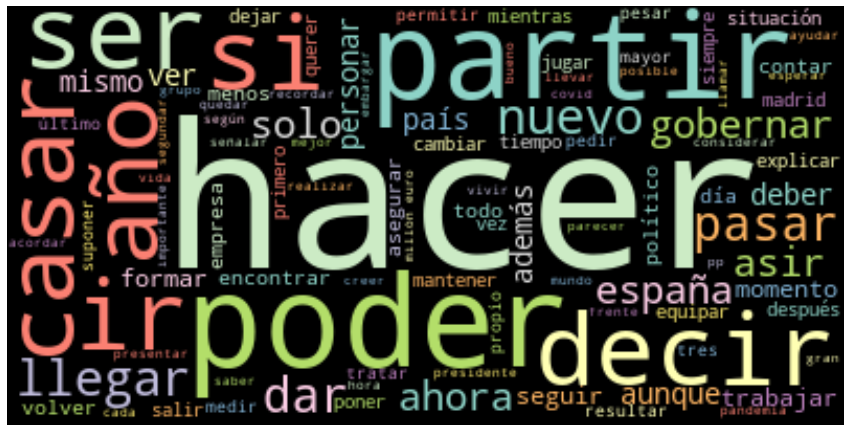

In [74]:
text = " ".join(str(each) for each in df_reales_v.Texto_2.unique())
wordcloud = WordCloud(max_words=100,colormap='Set3', background_color="black", random_state=123).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

#### 4.1.2. Análisis de frecuencias Noticias Reales

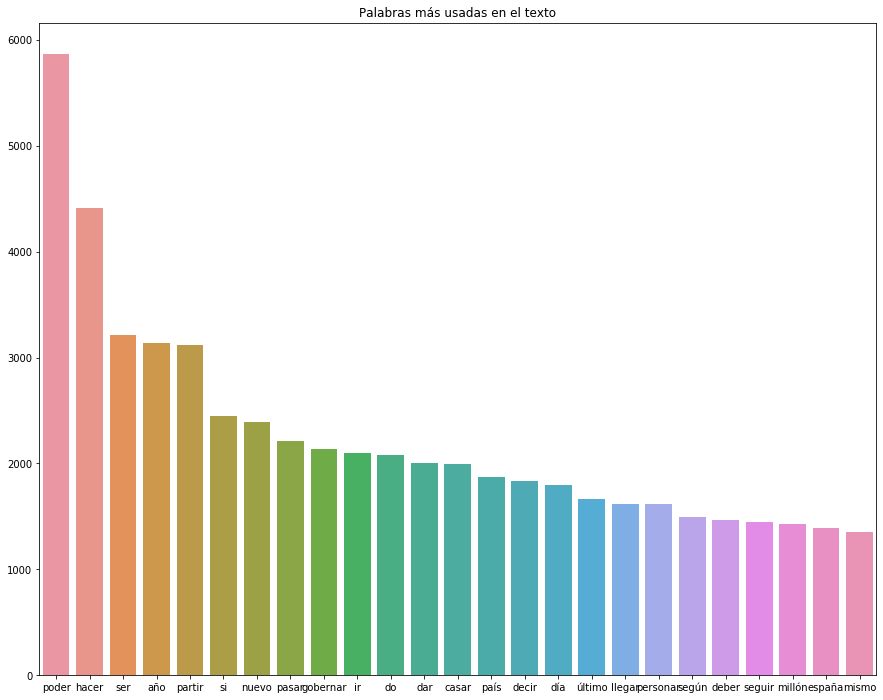

In [75]:
all_text = [text for text in df_reales_v['Texto_2']]
all_text_clean = ' '.join(all_text).split()
all_text_clean = [word for word in all_text_clean if word != '\'s']
all_text_counts = Counter(all_text_clean)
all_text_common_words = [word[0] for word in all_text_counts.most_common(25)]
all_text_common_counts = [word[1] for word in all_text_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=all_text_common_words, y=all_text_common_counts)
plt.title('Palabras más usadas en el texto')
plt.show()

### 4.2.  Noticias Falsas

In [76]:
df_falsas_v = df[df['Target']==1]

#### 4.2.1. Wordcloud

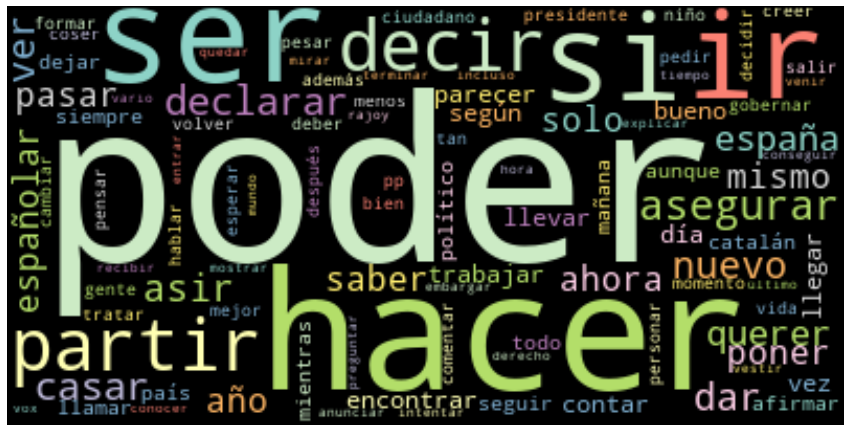

In [77]:
text = " ".join(str(each) for each in df_falsas_v.Texto_2.unique())
wordcloud = WordCloud(max_words=100,colormap='Set3', background_color="black", random_state=123).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.figure(1,figsize=(12, 12))
plt.show()

#### 4.2.2. Análisis de frecuencias Noticias falsas

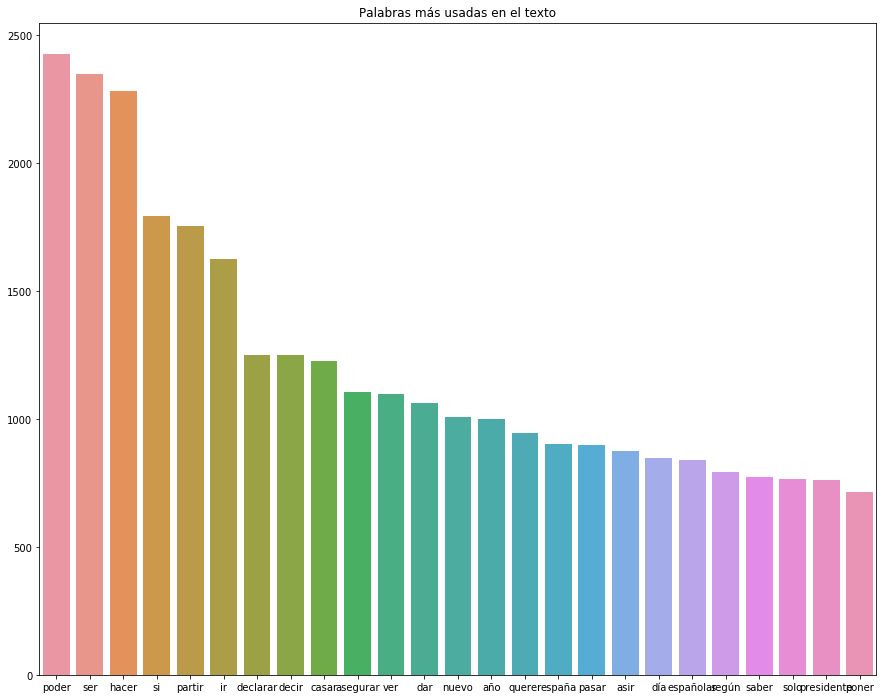

In [78]:
all_text = [text for text in df_falsas_v['Texto_2']]
all_text_clean = ' '.join(all_text).split()
all_text_clean = [word for word in all_text_clean if word != '\'s']
all_text_counts = Counter(all_text_clean)
all_text_common_words = [word[0] for word in all_text_counts.most_common(25)]
all_text_common_counts = [word[1] for word in all_text_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=all_text_common_words, y=all_text_common_counts)
plt.title('Palabras más usadas en el texto')
plt.show()

## 5. Modelos

### 5.1. Muestreo estratificaco

In [79]:
#X = df.Texto #Texto sin lematizar ni sin convertir a raíces
X = df.Texto_2 #Texto tras lematizar
#X = df.Texto_3 #Texto tras convertir a raíces
#X = df.Texto_4 #Texto tras lematizar y convertir a raíces

y = df.Target

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify = y)

Comprobamos que el muestreo es estratificado por la variable target

In [81]:
y_train.value_counts()

1    1849
0    1848
Name: Target, dtype: int64

In [82]:
y_test.value_counts()

0    463
1    462
Name: Target, dtype: int64

### 5.2. Métricas de análisis

In [83]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)
    plt.style.use('classic')

### 5.3. Desarrollo de modelos

#### 5.3.1. Naive Bayes

matriz de confusión
[[430  33]
 [ 43 419]]
accuracy
0.9178378378378378
precision
0.9269911504424779
recall
0.9069264069264069
f1
0.9168490153172867
AUC
0.9178260544351258


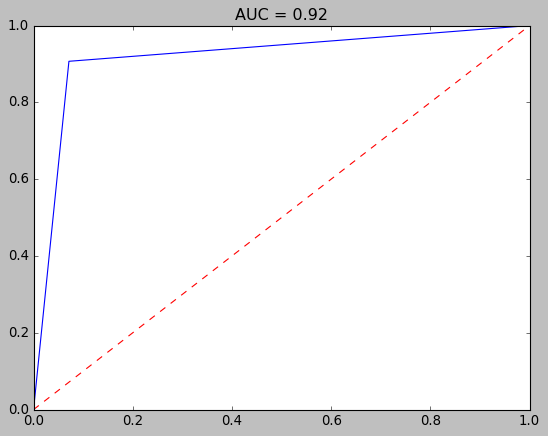

In [84]:
tfidf_vect = TfidfVectorizer()
algoritmo = MultinomialNB()

modelo1 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo1.predict(tfidf_vect.transform(X_test))
plt.style.use('classic')
saca_metricas(y_test, y_pred)

#### 5.3.2. Regresión Logística

matriz de confusión
[[438  25]
 [ 29 433]]
accuracy
0.9416216216216217
precision
0.9454148471615721
recall
0.9372294372294372
f1
0.9413043478260869
AUC
0.9416168784419325


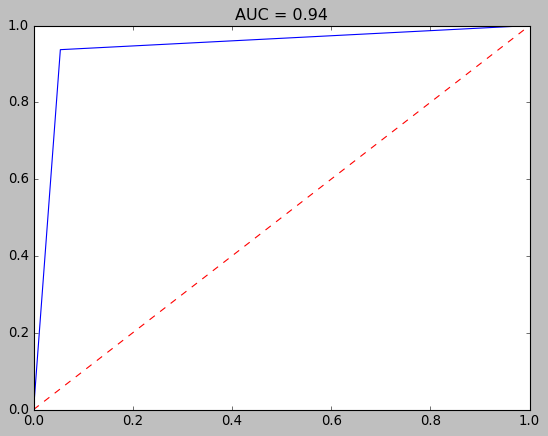

In [85]:
tfidf_vect = TfidfVectorizer()
algoritmo = LogisticRegression()

modelo2 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo2.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.3. Support Vector Classifier

matriz de confusión
[[446  17]
 [ 27 435]]
accuracy
0.9524324324324325
precision
0.9623893805309734
recall
0.9415584415584416
f1
0.9518599562363239
AUC
0.9524206894617262


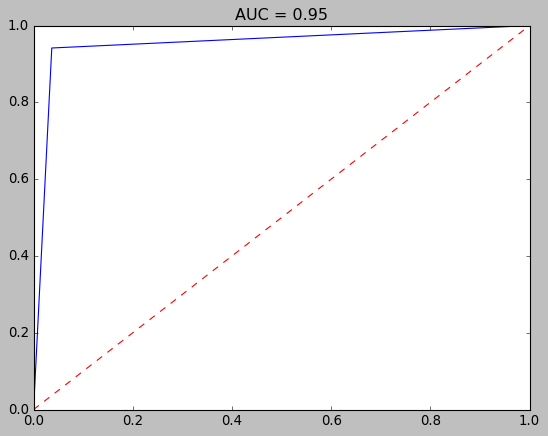

In [86]:
tfidf_vect = TfidfVectorizer()
algoritmo = SVC(probability=True)

modelo3 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo3.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.4. Árbol de decisión

matriz de confusión
[[371  92]
 [ 59 403]]
accuracy
0.8367567567567568
precision
0.8141414141414142
recall
0.8722943722943723
f1
0.8422152560083594
AUC
0.8367951343113329


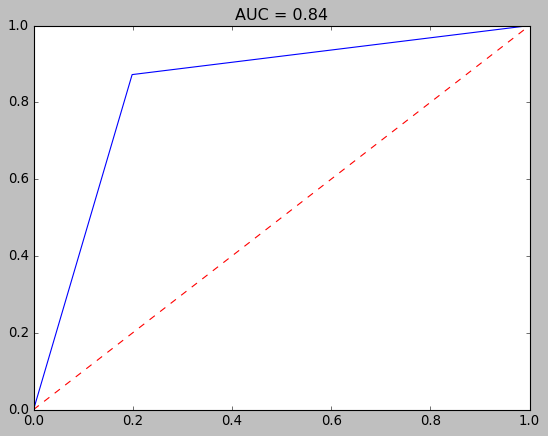

In [87]:
tfidf_vect = TfidfVectorizer()
algoritmo = DecisionTreeClassifier(random_state=42)

modelo4 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo4.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.5. Random Forest

matriz de confusión
[[400  63]
 [ 19 443]]
accuracy
0.9113513513513514
precision
0.8754940711462451
recall
0.9588744588744589
f1
0.9152892561983471
AUC
0.9114026722018083


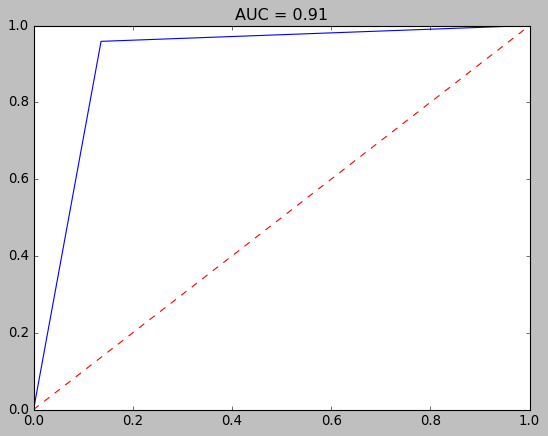

In [88]:
tfidf_vect = TfidfVectorizer()
algoritmo = RandomForestClassifier(random_state=42)

modelo5 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo5.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.6. XGBClassifier

matriz de confusión
[[448  15]
 [ 32 430]]
accuracy
0.9491891891891892
precision
0.9662921348314607
recall
0.9307359307359307
f1
0.948180815876516
AUC
0.9491692612642938


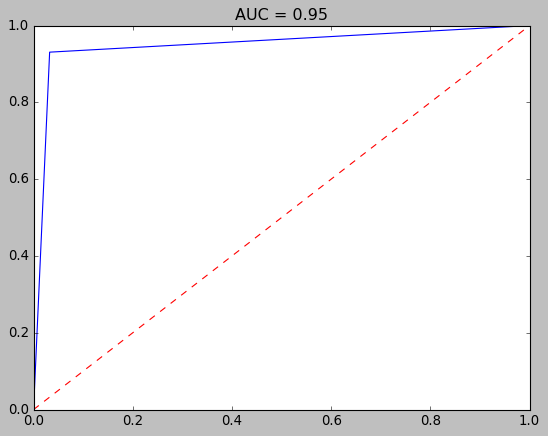

In [89]:
tfidf_vect = TfidfVectorizer()
algoritmo = XGBClassifier(random_state=42)

modelo6 = algoritmo.fit(tfidf_vect.fit_transform(X_train), y_train)
y_pred = modelo6.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

#### 5.3.7. Red Neuronal Long Short-Term Memory (LSTM)

Se tokenizan las muestras

In [90]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

Se prepara la red neuronal

In [91]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [92]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

Se ejecuta el modelo

In [93]:
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=5,
          validation_split=0.2)

Train on 2957 samples, validate on 740 samples
Epoch 1/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.5118 - accuracy: 0.7568 - val_loss: 0.2427 - val_accuracy: 0.9122
Epoch 2/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1641 - accuracy: 0.9499 - val_loss: 0.1664 - val_accuracy: 0.9446
Epoch 3/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1132 - accuracy: 0.9672 - val_loss: 0.1554 - val_accuracy: 0.9392
Epoch 4/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.0902 - accuracy: 0.9719 - val_loss: 0.2256 - val_accuracy: 0.9257
Epoch 5/5
2957/2957 [==============================] - 5s 2ms/step - loss: 0.1116 - accuracy: 0.9655 - val_loss: 0.1752 - val_accuracy: 0.9392


Evaluación de la muestra Test

In [94]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [95]:
accr = model.evaluate(test_sequences_matrix,y_test)

925/925 [==============================] - 1s 605us/step


In [96]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.193
  Accuracy: 0.938


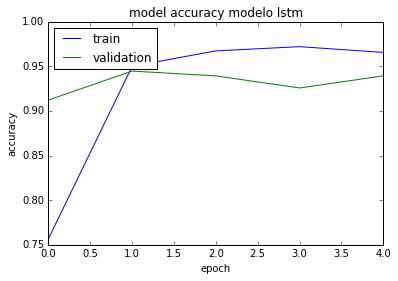

In [97]:
%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

## 6. Validación Cruzada

### 6.1. Naive Bayes

In [98]:
tfidf_vect = TfidfVectorizer()
algoritmo = MultinomialNB()
cv= StratifiedKFold(n_splits=5, random_state=42)
scores1 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores1 = pd.DataFrame(scores1, columns=['Accuracy'])
scores1.loc["Media"] = scores1.mean()
scores1.loc["Desv.Típica"] = scores1.std()
scores1

,Accuracy
0,0.912162
1,0.906757
2,0.905277
3,0.932341
4,0.924222
Media,0.916152
Desv.Típica,0.010485


### 6.2. Regresión Logística

In [99]:
tfidf_vect = TfidfVectorizer()
algoritmo = LogisticRegression()
cv= StratifiedKFold(n_splits=5, random_state=42)
scores2 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores2 = pd.DataFrame(scores2, columns=['Accuracy'])
scores2.loc["Media"] = scores2.mean()
scores2.loc["Desv.Típica"] = scores2.std()
scores2

,Accuracy
0,0.940541
1,0.928378
2,0.929635
3,0.936401
4,0.952639
Media,0.937519
Desv.Típica,0.008772


### 6.3. Support Vector Classifier

In [100]:
tfidf_vect = TfidfVectorizer()
algoritmo = SVC(probability=True)
cv= StratifiedKFold(n_splits=5, random_state=42)
scores3 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores3 = pd.DataFrame(scores3, columns=['Accuracy'])
scores3.loc["Media"] = scores3.mean()
scores3.loc["Desv.Típica"] = scores3.std()
scores3

,Accuracy
0,0.951351
1,0.945946
2,0.943166
3,0.948579
4,0.968877
Media,0.951584
Desv.Típica,0.009064


### 6.4. Árbol de decisión

In [101]:
tfidf_vect = TfidfVectorizer()
algoritmo = DecisionTreeClassifier(random_state=42)
cv= StratifiedKFold(n_splits=5, random_state=42)
scores4 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores4 = pd.DataFrame(scores4, columns=['Accuracy'])
scores4.loc["Media"] = scores4.mean()
scores4.loc["Desv.Típica"] = scores4.std()
scores4

,Accuracy
0,0.818919
1,0.831081
2,0.829499
3,0.837618
4,0.824087
Media,0.828241
Desv.Típica,0.006352


### 6.5. Random Forest

In [102]:
tfidf_vect = TfidfVectorizer()
algoritmo = RandomForestClassifier()
cv= StratifiedKFold(n_splits=5, random_state=42)
scores5 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores5 = pd.DataFrame(scores5, columns=['Accuracy'])
scores5.loc["Media"] = scores5.mean()
scores5.loc["Desv.Típica"] = scores5.std()
scores5

,Accuracy
0,0.924324
1,0.910811
2,0.907984
3,0.917456
4,0.928281
Media,0.917771
Desv.Típica,0.007717


### 6.6. XGBClassifier

In [103]:
tfidf_vect = TfidfVectorizer()
algoritmo = XGBClassifier(random_state=42)
cv= StratifiedKFold(n_splits=5, random_state=42)
scores6 = cross_val_score(algoritmo, tfidf_vect.fit_transform(X_train), y_train, scoring='accuracy', cv=cv)
scores6 = pd.DataFrame(scores6, columns=['Accuracy'])
scores6.loc["Media"] = scores6.mean()
scores6.loc["Desv.Típica"] = scores6.std()
scores6

,Accuracy
0,0.940541
1,0.927027
2,0.941813
3,0.943166
4,0.953992
Media,0.941308
Desv.Típica,0.008592


## 7. Ajuste de Hiperparámetros

Realizamos un estudio para la selección de los hiperparámetros que mejor optimicen cada uno de los modelos, ofreciendo diferentes opciones y considerando validación cruzada repetida.

### 7.1. Naive Bayes

Definición del modelo

In [104]:
nbayes = MultinomialNB()

Definición de los hiperparámetros

In [105]:
alpha = [0, 0.5, 1, 2]

fit_prior = [True, False]

hyperparameters = dict(alpha=alpha, fit_prior=fit_prior)

Definición del Gridsearch

In [106]:
clf = GridSearchCV(nbayes, hyperparameters, scoring='roc_auc', cv=5, verbose=0) 

Ejecución del grid search

In [107]:
tfidf_vect = TfidfVectorizer()
best_model1 = clf.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros resultantes

In [108]:
best_model1.best_estimator_.get_params()

{'alpha': 0.5, 'class_prior': None, 'fit_prior': True}

Obtención de la predicción

matriz de confusión
[[424  39]
 [ 36 426]]
accuracy
0.918918918918919
precision
0.9161290322580645
recall
0.922077922077922
f1
0.919093851132686
AUC
0.9189223303694146


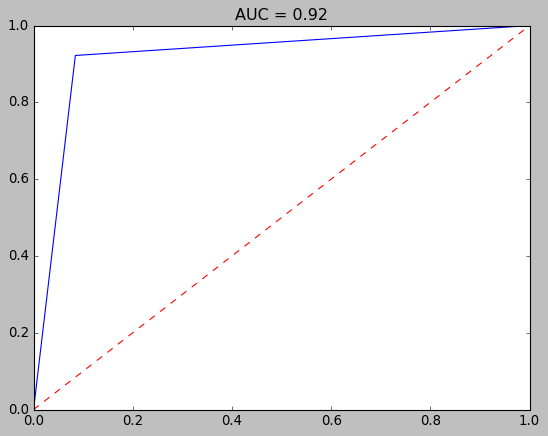

In [109]:
y_pred = best_model1.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.2. Regresión Logística

Definición del modelo

In [110]:
logistic = LogisticRegression()

In [111]:
penalty = ['l1', 'l2']

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

hyperparameters = dict(C=C, penalty=penalty)

Definición de la función GridSearch con cross-validation de 5 muestras

In [112]:
clf = GridSearchCV(logistic, hyperparameters, scoring='roc_auc', cv=5, verbose=0) 

Ejecución del GridSearch

In [113]:
tfidf_vect = TfidfVectorizer()
best_model2 = clf.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [114]:
best_model2.best_estimator_.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Predicción

matriz de confusión
[[443  20]
 [ 30 432]]
accuracy
0.9459459459459459
precision
0.9557522123893806
recall
0.935064935064935
f1
0.9452954048140044
AUC
0.9459341953942384


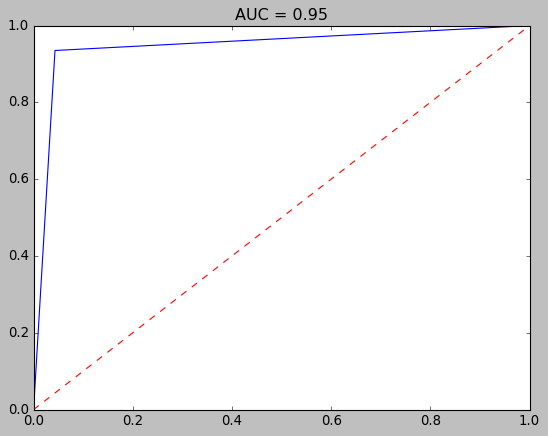

In [115]:
y_pred = best_model2.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.3. Support Vector Classififier

Definición del modelo

In [116]:
svm = SVC(probability=True)

Hiperparámetros

In [117]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100]}]

Ejecución Gridsearch

In [118]:
tfidf_vect = TfidfVectorizer()
grid = GridSearchCV(svm, tuned_parameters, scoring='roc_auc', cv=5) 
best_model3 = grid.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [119]:
best_model3.best_estimator_.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Predicción con el mejor modelo obtenido

matriz de confusión
[[446  17]
 [ 30 432]]
accuracy
0.9491891891891892
precision
0.9621380846325167
recall
0.935064935064935
f1
0.9484083424807903
AUC
0.9491739362149729


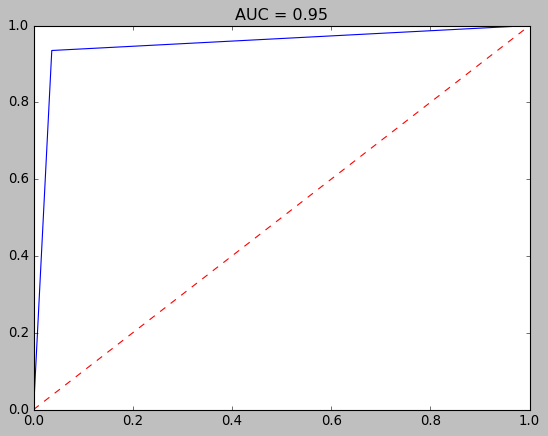

In [120]:
y_pred = best_model3.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.4. Decission Tree

Definición del modelo

In [121]:
dectree = DecisionTreeClassifier(random_state=42)

Hiperparámetros

In [122]:
parametros = {'max_depth': [None, 1, 3, 5, 10],
        'min_samples_split': [None, 1, 2],
        'max_features': [None, 1, 3, 5, 10],
        'random_state': [42]
        }

Ejecución del Gridsearch

In [123]:
tfidf_vect = TfidfVectorizer()
grid = GridSearchCV(dectree, parametros, scoring='roc_auc', cv=5) 
best_model4 = grid.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [124]:
best_model4.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

Predicción con el mejor modelo obtenido

matriz de confusión
[[409  54]
 [113 349]]
accuracy
0.8194594594594594
precision
0.8660049627791563
recall
0.7554112554112554
f1
0.806936416184971
AUC
0.8193902929324095


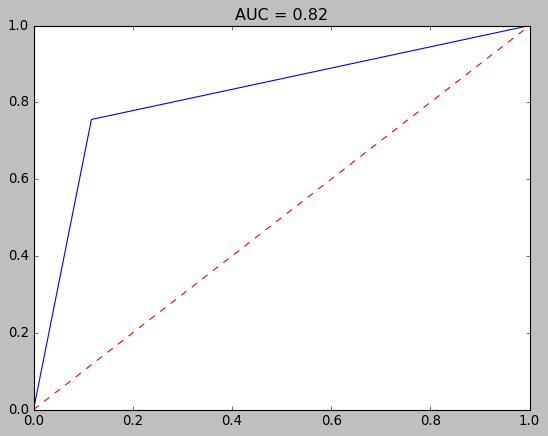

In [125]:
y_pred = best_model4.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.5. Random Forest

Definición del modelo

In [126]:
rfc=RandomForestClassifier(random_state=42)

Hiperparámetros

In [127]:
parametros = {'max_depth': [None, 1, 3, 8],
        'min_samples_split': [None, 1, 2],
        'max_features': [None, 1, 3, 8],
        'random_state': [42]
        }

Ejecución del Gridsearch

In [128]:
tfidf_vect = TfidfVectorizer()
CV_rfc = GridSearchCV(estimator=rfc, param_grid=parametros, scoring='roc_auc', cv= 5)
best_model5 = CV_rfc.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del mejor modelo

In [129]:
best_model5.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 8,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Predicción del mejor modelo

matriz de confusión
[[398  65]
 [ 18 444]]
accuracy
0.9102702702702703
precision
0.8722986247544204
recall
0.961038961038961
f1
0.9145211122554068
AUC
0.9103250960702365


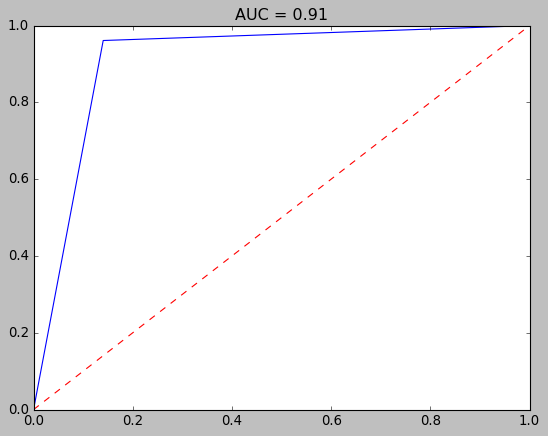

In [130]:
y_pred = best_model5.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.6. XGBClassifier

Definición del modelo

In [131]:
xgboost =XGBClassifier(random_state=42)

Hiperparámetros

In [132]:
params = {
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1],
        'max_depth': [3, 4, 5]
        }

In [133]:
tfidf_vect = TfidfVectorizer()
CV_rfc = GridSearchCV(estimator=xgboost, param_grid=params, scoring='roc_auc', cv= 5)
best_model6 = CV_rfc.fit(tfidf_vect.fit_transform(X_train), y_train)

Parámetros del modelo

In [134]:
best_model6.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.5,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None}

Predicción del mejor modelo

matriz de confusión
[[443  20]
 [ 31 431]]
accuracy
0.9448648648648649
precision
0.9556541019955654
recall
0.9329004329004329
f1
0.9441401971522454
AUC
0.9448519443119875


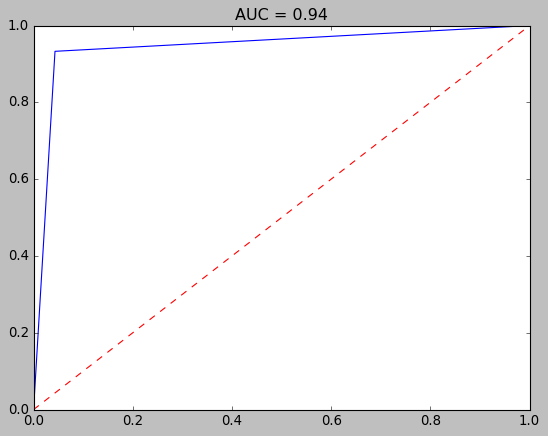

In [135]:
y_pred = best_model6.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

### 7.7. Red neuronal LSTM

No es posible realizar GridSearch para la red neuronal. Por ello, se probarán distintas opciones de ejecución de los parámetros de la red neuronal para averiguar qué opciones darían mejores resultados.

En primer lugar tokenizamos la base de datos

In [136]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

#### 7.7.1. Modificación de la densidad de las capas

Incremento de la densidad de las capas

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
FC1 (Dense)                  (None, 512)               66048     
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 513 

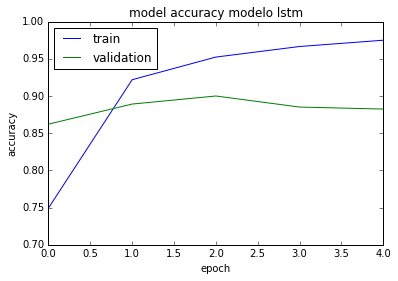

In [137]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(512,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

Decremento de la densidad de las capas

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
FC1 (Dense)                  (None, 128)               4224      
_________________________________________________________________
activation_5 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129 

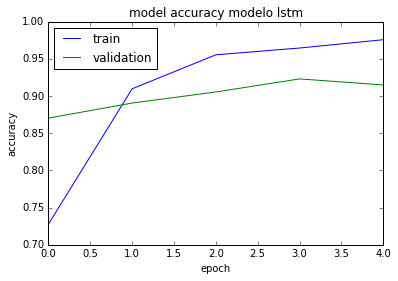

In [138]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(32)(layer)
    layer = Dense(128,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

#### 7.7.2. Modificación de batch size

Incremento de batch size

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

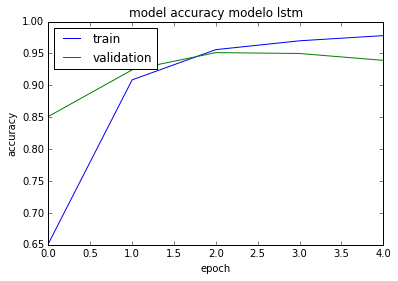

In [139]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=100,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

Decremento de batch size

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

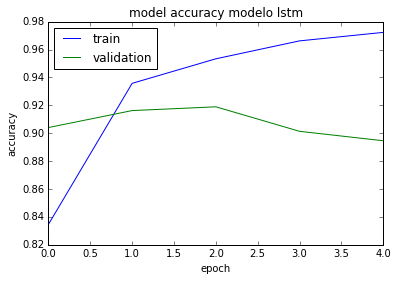

In [140]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=10,epochs=5,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

#### 7.7.3. Modificación de epoch

Incremento de epoch

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

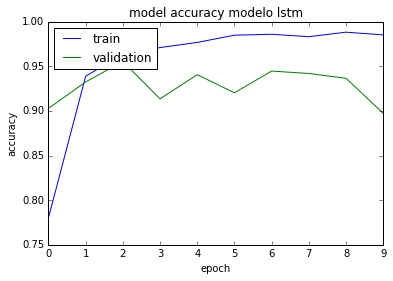

In [141]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=10,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

Decremento de epoch

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

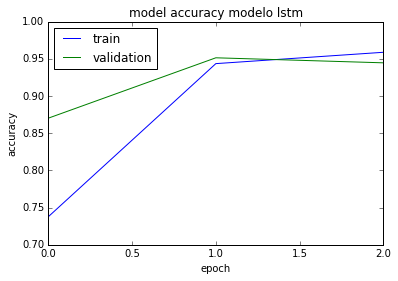

In [142]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=50,epochs=3,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')

#### 7.7.4. Modificación de múltiples parámetros

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                10624     
_________________________________________________________________
FC1 (Dense)                  (None, 128)               4224      
_________________________________________________________________
activation_15 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 129 

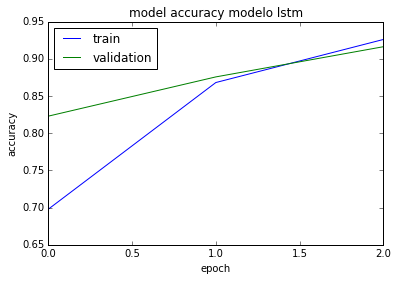

In [143]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(32)(layer)
    layer = Dense(128,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
modelo_lstm = model.fit(sequences_matrix,y_train,batch_size=100,epochs=3,
          validation_split=0.2)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

accr = model.evaluate(test_sequences_matrix,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

%matplotlib inline
plt.plot(modelo_lstm.history['accuracy'])
plt.plot(modelo_lstm.history['val_accuracy'])
plt.title('model accuracy modelo lstm')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.style.use('classic')


## 8. Guardamos el modelo final

Guardamos el modelo

In [144]:
filename = 'modelo_textos_largos.sav'
pickle.dump(best_model3, open(filename, 'wb'))

Probamos a cargar el modelo 

matriz de confusión
[[446  17]
 [ 30 432]]
accuracy
0.9491891891891892
precision
0.9621380846325167
recall
0.935064935064935
f1
0.9484083424807903
AUC
0.9491739362149729


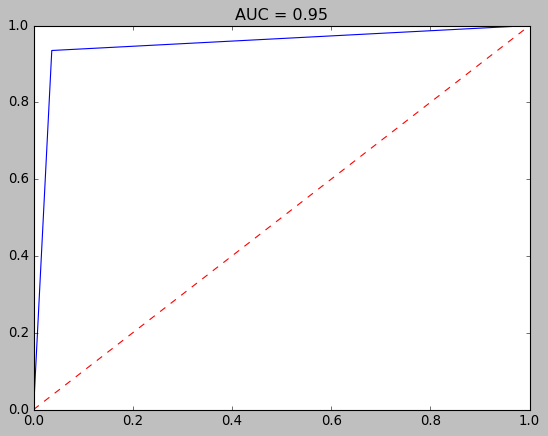

In [145]:
loaded_model = pickle.load(open('modelo_textos_largos.sav', 'rb'))
y_pred = loaded_model.predict(tfidf_vect.transform(X_test))
saca_metricas(y_test, y_pred)

## 9. Predicción noticias freelance

Cargamos el modelo

In [146]:
loaded_model = pickle.load(open('modelo_textos_largos.sav', 'rb'))

Importamos los datasets de noticias freelance. La presente ejecución se ha llevado a cabo con los siguientes archivos:

* freelance_19072020
* freelance_20072020

In [147]:
path = r'C:/Users/User/Desktop/Master/TFM/Fake_News/data/free' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_fake = pd.read_csv(filename, encoding='utf-8-sig', sep= ";")
    li.append(df_fake)

df_free_original = pd.concat(li, axis=0, ignore_index=True)

Analizamos las características del dataset

In [148]:
df_free_original.shape

(256, 10)

In [149]:
df_free_original.head(5)

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL
0,0,new_1,Menéame,Nueva Democracia Boliviana,Berlinguer,NaN,NaN,Tras 7 meses y medio de la llegada de los libe...,NaN,https://www.meneame.net/m/Art%C3%ADculos/nueva...
1,1,new_2,Menéame,Errores de concepto en el teletrabajo,Feindesland,NaN,NaN,Cuando se extiende un nuevo modo de hacer las ...,NaN,https://www.meneame.net/m/Art%C3%ADculos/error...
2,2,new_3,Menéame,Teletrabajo. Apertura de la competencia labora...,luigicomenccini,NaN,NaN,Para ver las repercusiones a medio plazo de la...,NaN,https://www.meneame.net/m/LuchaDClases/teletra...
3,3,new_4,Menéame,Debate para fijar los criterios a seguir en no...,Jakeukalane,NaN,NaN,De un tiempo a esta parte hay varios medios qu...,NaN,https://www.meneame.net/m/Art%C3%ADculos/crite...
4,4,new_5,Menéame,Pues yo creo que está subiendo el nivel,Feindesland,NaN,NaN,Nos quejamos siempre de nuestra propia decaden...,NaN,https://www.meneame.net/m/Art%C3%ADculos/pues-...


Analizamos si hay Textos a missing

In [150]:
df_free_original[df_free_original["Texto"].isnull()]

,Unnamed: 0,new_id,Web,Título,Autor,Cabecera,Comentarios,Texto,Página,URL
46,46,new_47,Menéame,La inflacion explicada,Nagash,NaN,NaN,NaN,NaN,https://www.meneame.net/m/Libertarios/inflacio...
63,63,new_64,Menéame,Mensaje a la población,Nagash,NaN,NaN,NaN,NaN,https://www.meneame.net/m/chorradas/mensaje-la...
176,46,new_47,Menéame,La inflacion explicada,Nagash,NaN,NaN,NaN,NaN,https://www.meneame.net/m/Libertarios/inflacio...
193,63,new_64,Menéame,Mensaje a la población,Nagash,NaN,NaN,NaN,NaN,https://www.meneame.net/m/chorradas/mensaje-la...


Eliminamos textos que están a missing por no poderles imputar el modelo

In [151]:
df_free = df_free_original[df_free_original.Texto.notnull()]

Nos quedamos únicamente con el texto

In [152]:
df_free = df_free[["Texto"]]

In [153]:
df_free.head(5)

,Texto
0,Tras 7 meses y medio de la llegada de los libe...
1,Cuando se extiende un nuevo modo de hacer las ...
2,Para ver las repercusiones a medio plazo de la...
3,De un tiempo a esta parte hay varios medios qu...
4,Nos quejamos siempre de nuestra propia decaden...


Eliminamos duplicados

In [154]:
df_free = df_free.drop_duplicates()

In [155]:
df_free.shape

(90, 1)

Llevamos a cabo las mismas tareas de pre-procesado que las realizadas en el desarrollo del modelo

In [156]:
#Eliminación de números
df_free["Texto"] = df_free["Texto"].apply(lambda x: elimina_numeros(x))

#Transformación a minúscula
df_free["Texto"] = df_free["Texto"].str.lower()


#Signos de puntuación
df_free["Texto"] = df_free['Texto'].str.replace('[{}]'.format(string.punctuation), '')
df_free['Texto'] = df_free['Texto'].str.replace('"', '')
df_free['Texto'] = df_free['Texto'].str.replace("\n", '')
df_free['Texto'] = df_free['Texto'].str.replace("•", '')
df_free['Texto'] = df_free['Texto'].str.replace("“", '')
df_free['Texto'] = df_free['Texto'].str.replace( "”", '')
df_free['Texto'] = df_free['Texto'].str.replace( '–', '')
df_free['Texto'] = df_free['Texto'].str.replace( '«', '')
df_free['Texto'] = df_free['Texto'].str.replace( '»', '')

#URL del texto
df_free["Texto"] = df_free["Texto"].apply(lambda x: remove_URL(x))

#Stopwords
df_free["Texto"] = df_free["Texto"].str.split()
df_free['Texto']= df_free['Texto'].apply(lambda x: [item for item in x if item not in stop])
df_free['Texto'] = df_free['Texto'].apply(lambda x: ','.join(map(str, x)))
df_free['Texto'] = df_free['Texto'].str.replace( ",", ' ')

#Lematización
df_free["Texto"] = df_free["Texto"].apply(lambda x: lematizar(x))
df_free['Texto'] = df_free['Texto'].apply(lambda x: ','.join(map(str, x)))
df_free['Texto'] = df_free['Texto'].str.replace( ",", ' ')

Seleccionamos la variable a predecir

In [157]:
X_free = df_free.iloc[:]

Realizamos la predicción

In [158]:
prediccion = pd.DataFrame(loaded_model.predict(tfidf_vect.transform(X_free.Texto)), columns=["Pred"])
prediccion = prediccion.reset_index()
prediccion

,index,Pred
0,0,1
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
85,85,1
86,86,1
87,87,0
88,88,0


Analizamos cuántos valores saldrían como fake news y cuántos como noticias reales

In [159]:
prediccion["Pred"].value_counts()

0    53
1    37
Name: Pred, dtype: int64

Calculamos la probabilidad asociada a ser noticia real y la asociada a noticia fake

In [160]:
prediccion_prob = pd.DataFrame(loaded_model.predict_proba(tfidf_vect.transform(X_free.Texto)), 
                               columns=["Prob Real", "Prob Fake"])
prediccion_prob = prediccion_prob.reset_index()
prediccion_prob

,index,Prob Real,Prob Fake
0,0,0.086362,0.913638
1,1,0.955647,0.044353
2,2,0.997599,0.002401
3,3,0.825403,0.174597
4,4,0.108370,0.891630
...,...,...,...
85,85,0.036271,0.963729
86,86,0.249745,0.750255
87,87,0.900070,0.099930
88,88,0.969127,0.030873


Cruzamos la información para analizar qué noticias saldrían fake

In [161]:
df_free_original = df_free_original.reset_index()
analisis_fake = pd.merge(prediccion, df_free_original, on='index', how='inner')
analisis_fake = pd.merge(analisis_fake, prediccion_prob, on='index', how='inner')

In [162]:
analisis_fake[["index", "Texto", "Pred", "Prob Real", "Prob Fake"]].head(10)

,index,Texto,Pred,Prob Real,Prob Fake
0,0,Tras 7 meses y medio de la llegada de los libe...,1,0.086362,0.913638
1,1,Cuando se extiende un nuevo modo de hacer las ...,0,0.955647,0.044353
2,2,Para ver las repercusiones a medio plazo de la...,0,0.997599,0.002401
3,3,De un tiempo a esta parte hay varios medios qu...,0,0.825403,0.174597
4,4,Nos quejamos siempre de nuestra propia decaden...,1,0.108370,0.891630
5,5,¿Eres de lo que tiene alergia a todo lo digita...,1,0.204344,0.795656
6,6,Los que tenemos ya cierta edad recordamos que ...,1,0.014290,0.985710
7,7,"No recuerdo dónde encontré dicho ranking, pero...",0,0.645519,0.354481
8,8,"En toda la historia ninguna cultura, ninguna c...",0,0.744864,0.255136
9,9,Un artículo publicado y en portada esta mañana...,0,0.858795,0.141205
